In [1]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Adamax
import keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
parser.add_argument('-cv_path' ,'--cv_path', type=str, default='/home/katieyth/gynecology/data/5_fold_CMU_rs_13/', help='cv_path')

 
# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-struc' ,'--struc', type=str, default='man_concat', help='deeper or shallower')
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=5, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=27, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=15, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='7', help='GPU ID')
parser.add_argument('-fd' ,'--fold', type=int, default=1, help='CMU_5_fold')
parser.add_argument('-fn' ,'--summary_file', type=str, default='', help='summary filename')

FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

In [3]:
def data_preprocess_test(Xvalid, Yvalid, length=600):
    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    Ytest = Yvalid.copy()
    return Xtest, Ytest

In [4]:
### data preparing
train_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_train.csv' %(FLAG.fold)))
valid_d = pd.read_csv(os.path.join(FLAG.cv_path, '5_fold_0%s_test.csv' %(FLAG.fold)))


# replace 0 (no readings) with np.nan for later substitution
for k in train_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        train_d.loc[train_d[k]==0, k] = np.nan
for k in valid_d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        valid_d.loc[valid_d[k]==0, k] = np.nan

    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
target_list = ['management', 'UA', 'variability', 'deceleration',  'management']
target_dict = {'management':3,
               'UA':2,
               'variability':2,
               'deceleration':4,
               'management':3}
Ytrain = [(keras.utils.to_categorical(np.array(train_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]
Yvalid = [(keras.utils.to_categorical(np.array(valid_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]

#weight balancing or not
if FLAG.weight_balance:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        y_integers = np.argmax(Ytrain[idx], axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)
else:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        class_weight = dict()
        for i in range(target_dict[c_name]):
            class_weight[i] = 1
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)

Xtest, Ytest =data_preprocess_test(Xvalid, Yvalid)


if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

print('train:', len(train_d))
print('test:', len(valid_d))

class weight: {0: 0.5142857142857142, 1: 1.0384615384615385, 2: 10.8}
class weight: {0: 5.4, 1: 0.5510204081632653}
class weight: {0: 0.5664335664335665, 1: 4.2631578947368425}
class weight: {0: 0.4308510638297872, 1: 1.9285714285714286, 2: 0.9, 3: 20.25}
class weight: {0: 0.5142857142857142, 1: 1.0384615384615385, 2: 10.8}
train: 162
test: 45


# model

In [5]:
if FLAG.struc =='deeper':
    from model_multitask_more import build_model
elif FLAG.struc =='shallower':
    from model_multitask import build_model
elif FLAG.struc =='man_concat':
    from model_multitask_more_concat import build_model
elif FLAG.struc =='man_concat_shallower':
    from model_multitask_more_concat_shallower import build_model
elif FLAG.struc =='mimic_previous':
    from model_multitask_more_concat_mimic_previous import build_model
elif FLAG.struc =='mimic_previous_FHB':
    from model_multitask_more_concat_mimic_previous_FHB import build_model

In [6]:
augtool = (DA_Shift,DA_Scale,DA_RandSampling)
choose_augtool = (FLAG.DA_Shift,FLAG.DA_Scale,FLAG.DA_RandSampling)
augset = [x for x, y in zip(augtool, choose_augtool) if y == 1]
augset

[<function func.DA_Shift>,
 <function func.DA_Scale>,
 <function func.DA_RandSampling>]

In [7]:
def my_generator(Xtrain, Ytrain, tg_list, tg_dict,
                 length=300, n_channel=2,  batch_size=16, prob=0.5,
                 aug_func=[], random_noise = False, normalized = True):
    n_sample = Xtrain.shape[0]
    n_length = Xtrain.shape[1]
    ind = list(range(n_sample))
    x = np.empty((batch_size, length, n_channel), dtype=np.float)
    
    y_list = [(np.empty((batch_size, tg_dict[c_name]), dtype=int)) for c_name in tg_list]

    while True:
        np.random.shuffle(ind)
        for i in range(n_sample//batch_size):
            if length==600:
                st = 0
            else:
                st = random.choice(np.arange(0, Xtrain.shape[1] - length))
            i_batch = ind[i*batch_size:(i+1)*batch_size]
            for j, k in enumerate(i_batch):
                x[j,:] = data_preprocess(Xtrain[k,st:(st+length),:], aug_func=aug_func, prob=prob, random_noise=random_noise, normalized=normalized)
                for c_idx in range(len(tg_list)):
                    y_list[c_idx][j,:] = Ytrain[c_idx][k,:] 
                
            yield x, y_list

In [8]:
train_gen = my_generator(Xtrain, Ytrain, 
                         tg_list = target_list,
                         tg_dict = target_dict,
                        length=FLAG.length, 
                        n_channel=FLAG.n_channel, 
                        random_noise=FLAG.random_noise,
                        normalized=FLAG.normalized,
                        batch_size=FLAG.batch_size,
                        aug_func=augset,
                        prob=0.25)

In [9]:
# Get a "l2 norm of gradients" tensor
def get_gradient_norm(model):
    with K.name_scope('gradient_norm'):
        grads = K.gradients(model.total_loss, model.trainable_weights)
        norm = K.sqrt(sum([K.sum(K.square(g)) for g in grads]))
    return norm

In [10]:
print("===== create directory =====")
model_id = FLAG.target + "_" + datetime.now().strftime("%y%m%d%H%M%S")
model_save = os.path.join(FLAG.model_save, FLAG.target, model_id)
summary_save = os.path.join(FLAG.model_save, FLAG.target, 'summary_'+FLAG.target+'_'+FLAG.summary_file+'.csv')

if not os.path.exists(model_save):
    os.makedirs(model_save)
    print(model_save)

# declare model and compile it 
model = build_model(length=FLAG.length, n_channel=FLAG.n_channel,  filters=FLAG.filters,
                    kernel_size=FLAG.kernel_size, layers=FLAG.layers,
                activation=FLAG.activation, kernel_initializer=FLAG.kernel_initializer, l_2=FLAG.l2)
model.summary()
lr_rate = FLAG.learning_rate
adam = Adamax(lr_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 還沒有 compile 前拿不到 total loss 這個 tensor, 也拿不到 metrics 這個東西
# Append the "l2 norm of gradients" tensor as a metric
model.metrics_names.append("gradient_norm")
model.metrics_tensors.append(get_gradient_norm(model))


csv_logger = CSVLogger(os.path.join(model_save, 'training.log'), append = True)
checkpoint = ModelCheckpoint(os.path.join(model_save, 'model.h5'), 
                                            monitor=FLAG.monitor, 
                                            verbose=1, 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto',
                                            period=1)
earlystop = EarlyStopping(monitor = FLAG.monitor, patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=FLAG.monitor, factor = 0.5, patience = FLAG.reduce_lr_patience, min_lr = 0, cooldown = 5, verbose = True)

===== create directory =====
/home/katieyth/gynecology/model_save/multi/multi_190119171155
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 600, 64)      0           batch_normalization_1[0][0]      
__________________

__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          16512       batch_normalization_17[0][0]     
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       batch_normalization_19[0][0]     
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128)          512         dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128)          512         dense_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128)          512         dense_3[0][0]                    
__________

In [11]:
model.fit_generator(generator=train_gen,
                    class_weight={'man': weight_list[0],
                                  'ua' : weight_list[1],
                                  'var': weight_list[2],
                                  'dec': weight_list[3],
                                 'man_concat':weight_list[0]},
                    validation_data=(Xtest, {'man':Ytest[0],
                                             'ua' :Ytest[1],
                                             'var':Ytest[2],
                                             'dec':Ytest[3],
                                            'man_concat':Ytest[4]}),
                    steps_per_epoch=50, 
                    epochs=FLAG.epoch,
                    verbose=1,
                    callbacks=[csv_logger,
                            reduce_lr, 
                            checkpoint,
                            earlystop
                              ])

Epoch 1/15
49/50 [============================>.] - ETA: 0s - loss: 28.6345 - man_loss: 1.6627 - ua_loss: 0.5873 - var_loss: 0.7012 - dec_loss: 1.5823 - man_concat_loss: 1.0262 - man_acc: 0.0612 - ua_acc: 0.6183 - var_acc: 0.5170 - dec_acc: 0.2600 - man_concat_acc: 0.4777 - gradient_norm: 41.1094
Epoch 00001: val_man_acc improved from -inf to 0.11111, saving model to /home/katieyth/gynecology/model_save/multi/multi_190119171155/model.h5
50/50 [==============================] - 22s 447ms/step - loss: 28.6037 - man_loss: 1.6569 - ua_loss: 0.5846 - var_loss: 0.6975 - dec_loss: 1.5720 - man_concat_loss: 1.0187 - man_acc: 0.0607 - ua_acc: 0.6193 - var_acc: 0.5126 - dec_acc: 0.2615 - man_concat_acc: 0.4830 - gradient_norm: 40.7538 - val_loss: 28.0112 - val_man_loss: 1.8170 - val_ua_loss: 0.5551 - val_var_loss: 0.5401 - val_dec_loss: 1.1698 - val_man_concat_loss: 0.8974 - val_man_acc: 0.1111 - val_ua_acc: 0.6667 - val_var_acc: 0.7111 - val_dec_acc: 0.4000 - val_man_concat_acc: 0.5778 - val_gr

50/50 [==============================] - 4s 76ms/step - loss: 25.7988 - man_loss: 0.9427 - ua_loss: 0.3798 - var_loss: 0.5126 - dec_loss: 0.8398 - man_concat_loss: 0.5979 - man_acc: 0.3015 - ua_acc: 0.7289 - var_acc: 0.6215 - dec_acc: 0.6037 - man_concat_acc: 0.6644 - gradient_norm: 24.2824 - val_loss: 26.2804 - val_man_loss: 1.2123 - val_ua_loss: 0.4694 - val_var_loss: 0.4248 - val_dec_loss: 0.9228 - val_man_concat_loss: 0.7589 - val_man_acc: 0.4222 - val_ua_acc: 0.7556 - val_var_acc: 0.8222 - val_dec_acc: 0.6000 - val_man_concat_acc: 0.6444 - val_gradient_norm: 40.2827
Epoch 10/15
49/50 [============================>.] - ETA: 0s - loss: 25.6829 - man_loss: 0.9283 - ua_loss: 0.3802 - var_loss: 0.4936 - dec_loss: 0.8171 - man_concat_loss: 0.6033 - man_acc: 0.3379 - ua_acc: 0.7415 - var_acc: 0.6674 - dec_acc: 0.5873 - man_concat_acc: 0.6553 - gradient_norm: 26.3319 ETA: 1s - loss: 25.7660 - man_loss: 0.9481 - ua_loss: 0.3807 - var_loss: 0.5023 - dec_loss: 0.8352 - man_concat_loss: 0.626

In [12]:
def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False, gradient=False):
    if type(csv_logger) is str:
        loss = pd.read_table(csv_logger, delimiter=',')
    else:
        loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_dec_acc), np.argmax(loss.val_dec_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='dec_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_dec_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'dec_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_var_acc), np.argmax(loss.val_var_acc)))
        plt.plot(loss.epoch, loss.var_acc, label='var_acc')
        plt.plot(loss.epoch, loss.val_var_acc, label='val_var_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'var_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_ua_acc), np.argmax(loss.val_ua_acc)))
        plt.plot(loss.epoch, loss.ua_acc, label='ua_acc')
        plt.plot(loss.epoch, loss.val_ua_acc, label='val_ua_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'ua_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_acc), np.argmax(loss.val_man_acc)))
        plt.plot(loss.epoch, loss.man_acc, label='man_acc')
        plt.plot(loss.epoch, loss.val_man_acc, label='val_man_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_concat_acc), np.argmax(loss.val_man_concat_acc)))
        plt.plot(loss.epoch, loss.man_concat_acc, label='man_concat_acc')
        plt.plot(loss.epoch, loss.val_man_concat_acc, label='val_man_concat_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_concat_acc.png'))
        plt.show()
        plt.close()
    if gradient:
        plt.plot(loss.epoch, loss.gradient_norm, label='gradient_norm')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('gradient_norm')
        plt.savefig(os.path.join(save_dir, 'gradient.png'))
        plt.show()
        plt.close()

min val_loss 25.3019718170166 at epoch 14


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


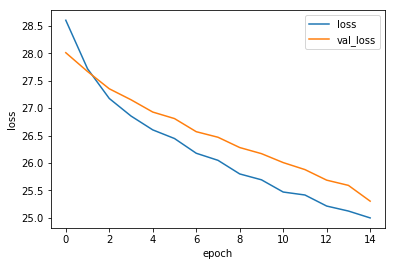

max val_accu 0.6666666865348816 at epoch 9


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


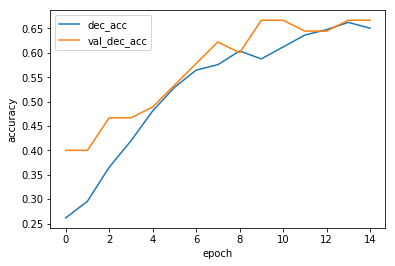

max val_accu 0.8888888955116272 at epoch 14


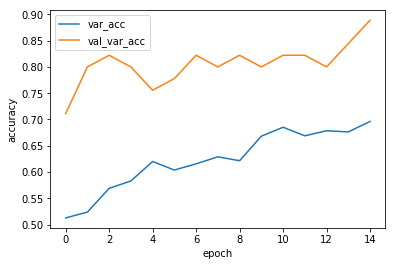

max val_accu 0.7555555462837219 at epoch 2


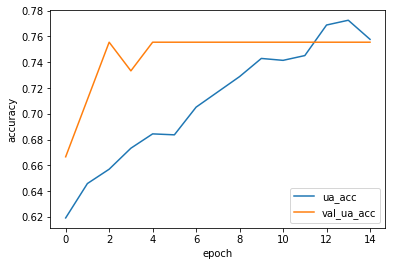

max val_accu 0.6222222447395325 at epoch 14


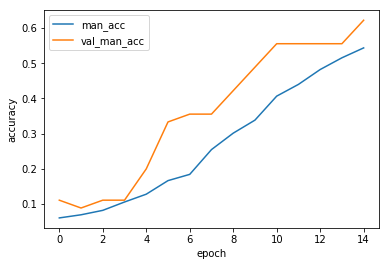

max val_accu 0.6888888716697693 at epoch 14


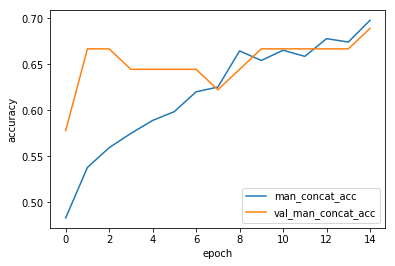

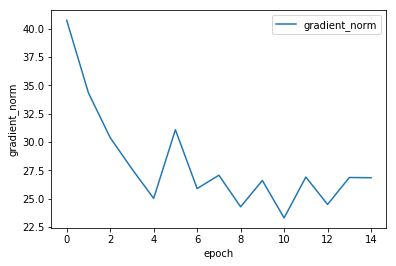

In [13]:
plot_keras_csv_logger(csv_logger, save_dir=model_save, accuracy=True, gradient = True)

# test saved model

In [14]:
path = model_save
print(path)
loss = pd.read_table(csv_logger.filename, delimiter=',')
best_val_loss = np.min(loss.val_loss)
best_epoch = np.argmin(loss.val_loss)


# model_id =  'multi_190114123245'
# path = os.path.join(FLAG.model_save,FLAG.target, model_id)
# loss = pd.read_table(os.path.join(path, 'training.log'), delimiter=',')
# best_val_loss = np.min(loss.val_loss)
# best_epoch = np.argmin(loss.val_loss)
# model_save = '.'


/home/katieyth/gynecology/model_save/multi/multi_190119171155


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [15]:
# evaluate validation set
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save_dir=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if not save_dir =='':
        plt.savefig(os.path.join(save_dir))

management accuracy :  0.6222222222222222
management_recall-0 : 0.7857
management_recall-1 : 0.3333
management_recall-2 : 0.5000
management_recall-average : 0.5397
management_precision-0: 0.7857
management_precision-1: 0.5000
management_precision-2: 0.1429
management_precision-average : 0.4762
management_F1-0: 0.7857
management_F1-1: 0.4000
management_F1-2: 0.2222
management_F1-average : 0.4693
Confusion matrix, without normalization
[[22  4  2]
 [ 6  5  4]
 [ 0  1  1]]
UA accuracy :  0.7555555555555555
UA_recall-0 : 0.8000
UA_recall-1 : 0.7500
UA_recall-average : 0.7750
UA_precision-0: 0.2857
UA_precision-1: 0.9677
UA_precision-average : 0.6267
UA_F1-0: 0.4211
UA_F1-1: 0.8451
UA_F1-average : 0.6331
Confusion matrix, without normalization
[[ 4  1]
 [10 30]]
variability accuracy :  0.8888888888888888
variability_recall-0 : 0.9000
variability_recall-1 : 0.8000
variability_recall-average : 0.8500
variability_precision-0: 0.9730
variability_precision-1: 0.5000
variability_precision-average

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



deceleration_F1-average : 0.4635
Confusion matrix, without normalization
[[17  6  0  2]
 [ 2  2  1  1]
 [ 0  3 11  0]
 [ 0  0  0  0]]
management_concat accuracy :  0.6888888888888889
management_concat_recall-0 : 0.8214
management_concat_recall-1 : 0.4667
management_concat_recall-2 : 0.5000
management_concat_recall-average : 0.5960
management_concat_precision-0: 0.7931
management_concat_precision-1: 0.5385
management_concat_precision-2: 0.3333
management_concat_precision-average : 0.5550
management_concat_F1-0: 0.8070
management_concat_F1-1: 0.5000
management_concat_F1-2: 0.4000
management_concat_F1-average : 0.5690
Confusion matrix, without normalization
[[23  5  0]
 [ 6  7  2]
 [ 0  1  1]]
management_2_recall-0 : 0.7857
management_2_recall-1 : 0.6471
management_2_recall-average : 0.7164
management_2_precision-0: 0.7857
management_2_precision-1: 0.6471
management_2_precision-average : 0.7164
management_2_F1-0: 0.7857
management_2_F1-1: 0.6471
management_2_F1-average : 0.7164
Confusion

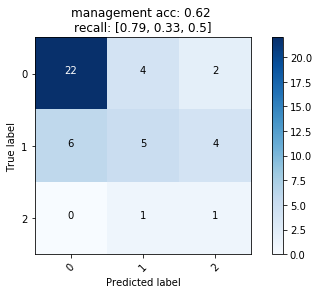

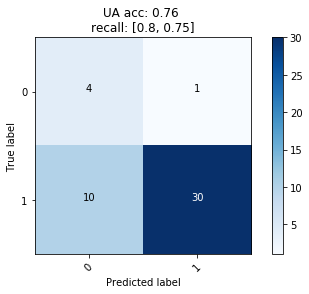

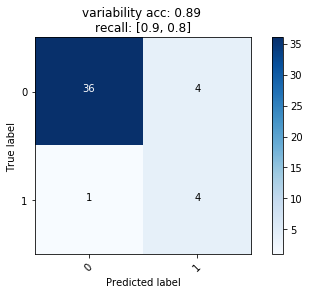

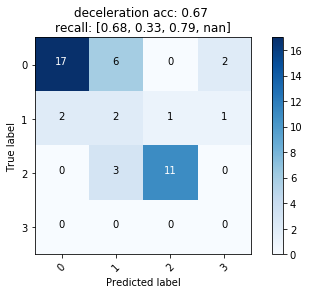

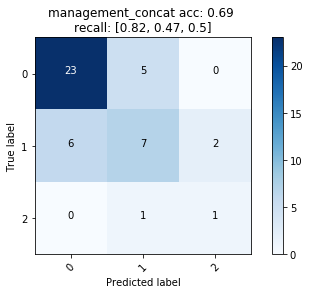

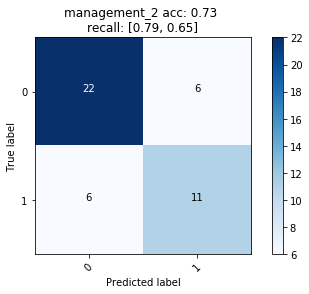

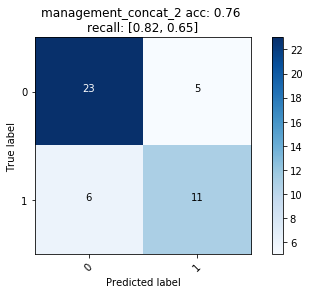

In [17]:
# save into dictionary
sav = vars(FLAG)
sav['epoch'] = best_epoch
sav['val_loss'] = best_val_loss
sav['model_id'] = model_id

c_list = ['management', 'UA', 'variability', 'deceleration', 'management_concat']
for c in range(len(c_list)):
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
    
    

    print('%s accuracy : ' % (c_list[c]), val_accu)
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[c],i, recall[i]))
        sav['%s_recall-%d' %(c_list[c], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[c],i, precision[i]))
        sav['%s_precision-%d' %(c_list[c], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[c],i, f1[i]))
        sav['%s_F1-%d' %(c_list[c], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[c])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)),
                          title='%s acc: %.2f \nrecall: %s' %(c_list[c], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[c]) )
# force management to 2 label 
c_list = ['management_2', 'management_concat_2']
for idx, c in enumerate([0,4]):
    # evaluate by every segment
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)
    ypred_aug[ypred_aug>1]=1
    ytest_aug[ytest_aug>1]=1

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
    
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[idx],i, recall[i]))
        sav['%s_recall-%d' %(c_list[idx], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[idx],i, precision[i]))
        sav['%s_precision-%d' %(c_list[idx], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[idx],i, f1[i]))
        sav['%s_F1-%d' %(c_list[idx], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[idx])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)), 
                          title='%s acc: %.2f \nrecall: %s' %(c_list[idx], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[idx]) )


In [18]:
# append into summary files
dnew = pd.DataFrame(sav, index=[0])
if os.path.exists(summary_save):
    dori = pd.read_csv(summary_save)
    dori = pd.concat([dori, dnew])
    dori.to_csv(summary_save, index=False)
else:
    dnew.to_csv(summary_save, index=False)

print(summary_save)



/home/katieyth/gynecology/model_save/multi/summary_multi_.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
